# 12 - Advanced topics - AgriPV Clearance Height Evaluation

This journal is based on Journal 11, now looping through various clearance-heights of the modules to evaluate ground irradiance and bifacial gain.


![AgriPV Bifacial Clearance Height Study](../images_wiki/AdvancedJournals/AgriPV_CHStudy.PNG)


<a id='step1'></a>

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' / 'AgriPVStudy')

# Another option using relative address; for some operative systems you might need '/' instead of '\'
# testfolder = os.path.abspath(r'..\..\bifacial_radiance\TEMP')  

try:
    os.stat(testfolder)
except:
    os.mkdir(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\Silvana\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\AgriPVStudy


In [2]:
from bifacial_radiance import *   
import numpy as np
import datetime

In [3]:
startdt_tomato =datetime.datetime(2001,3,15,0)
enddt_tomato = datetime.datetime(2001,6,30,23)
startdt_kale = datetime.datetime(2001,9,15,0)
enddt_kale = datetime.datetime(2001,10,31,23)
startdt_PV = datetime.datetime(2001,1,1,0)
enddt_PV = datetime.datetime(2001,12,31,23)

In [4]:
hub_heights = [4.3, 3.5, 2.5, 1.5]
albedo = 0.2  #'grass'     # ground albedo
crops = ['tomato', 'kale']

# Redundant. Overwritihng the Radiance Obj for each loop below to have a unique name.
demo = RadianceObj('getEPW_notused', path=testfolder)  # Create a RadianceObj 'object'
demo.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.
lat = 32.22  # Tucson, AZ
lon = -110.97  # Tucson, Az 32.2226° N, 110.9747° W
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057

path = C:\Users\Silvana\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\AgriPVStudy
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Tucson.Intl.AP.722740_TMY3.epw
 ... OK!


## 1. Loop over the different heights

In [5]:
for jj in range (0, len(hub_heights)):
    hub_height = hub_heights[jj]
    simulationname = 'height_'+ str(int(hub_height*100))+'cm'

    #Location:
    # MakeModule Parameters
    moduletype='PrismSolar'
    numpanels = 3  # AgriPV site has 3 modules along the y direction (N-S since we are facing it to the south) .
    x = 0.95  
    y = 1.95
    xgap = 2.0# Leaving 15 centimeters between modules on x direction
    ygap = 0.10 # Leaving 10 centimeters between modules on y direction
    zgap = 0 # no gap to torquetube.
    sensorsy = 6*numpanels  # this will give 6 sensors per module, 1 per cell

    # Other default values:

    # TorqueTube Parameters
    axisofrotationTorqueTube=False
    torqueTube = False
    cellLevelModule = True

    numcellsx = 12
    numcellsy = 6
    xcell = 0.156
    ycell = 0.156
    xcellgap = 0.02
    ycellgap = 0.02

    cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                             'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

    # SceneDict Parameters
    pitch = 15 # m
    torquetube_height = hub_height - 0.1 # m
    nMods = 6 # six modules per row.
    nRows = 3  # 3 row

    azimuth_ang=180 # Facing south
    tilt =35 # tilt. 

    # Now let's run the example
    demo = RadianceObj(simulationname,path = testfolder)  # Create a RadianceObj 'object'
    demo.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.

    #demo.gendaylit(4020)  # Use this to simulate only one hour at a time. 
    # Making module with all the variables
    module = demo.makeModule(name=moduletype, x=x, y=y, numpanels=numpanels, 
                               xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams)
    # create a scene with all the variables
    sceneDict = {'tilt':tilt, 'pitch':15, 'hub_height':hub_height, 'azimuth':azimuth_ang, 'nMods':nMods, 'nRows':nRows}  
    scene = demo.makeScene(module=moduletype, sceneDict=sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object fil|es into a .oct file.

    torquetubelength = module.scenex*(nMods) 

    # torquetube 1
    name='Post1'
    text='! genbox Metal_Aluminum_Anodized torquetube_row1 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 0 {}'.format(torquetubelength, (-torquetubelength+module.sceney)/2.0, torquetube_height)
    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

    name='Post2'
    text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 15 {}'.format(torquetubelength, (-torquetubelength+module.sceney)/2.0, torquetube_height)
    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

    name='Post3'
    text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 -15 {}'.format(torquetubelength, (-torquetubelength+module.sceney)/2.0, torquetube_height)
    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")

    name='Pile'
    pile1x = (torquetubelength+module.sceney)/2.0
    pilesep = pile1x*2.0/7.0
    #! genrev Metal_Grey tube1 t*1.004 0.05 32 | xform -ry 90 -t -0.502 0 0
    text= '! genrev Metal_Grey tube1row1 t*{} 0.15 32 | xform -t {} 0 0'.format(torquetube_height, pile1x)
    text += '\r\n! genrev Metal_Grey tube1row2 t*{} 0.15 32 | xform -t {} 15 0'.format(torquetube_height, pile1x)
    text += '\r\n! genrev Metal_Grey tube1row3 t*{} 0.15 32 | xform -t {} -15 0'.format(torquetube_height, pile1x)

    for i in range (1, 7):
        text += '\r\n! genrev Metal_Grey tube{}row1 t*{} 0.15 32 | xform -t {} 0 0'.format(i+1, torquetube_height, pile1x-pilesep*i)
        text += '\r\n! genrev Metal_Grey tube{}row2 t*{} 0.15 32 | xform -t {} 15 0'.format(i+1, torquetube_height, pile1x-pilesep*i)
        text += '\r\n! genrev Metal_Grey tube{}row3 t*{} 0.15 32 | xform -t {} -15 0'.format(i+1, torquetube_height, pile1x-pilesep*i)

    customObject = demo.makeCustomObject(name,text)
    demo.appendtoScene(radfile=scene.radfiles, customObject=customObject, text="!xform -rz 0")


    for zz in range (0, len(crops)):
        crop = crops[zz]
        if crop == 'tomato':
            #startdt =datetime.datetime(2001,3,15,0)
            #enddt = datetime.datetime(2001,6,30,23)
            starttime = '2001-03-15_0100' 
            endtime = '2001-06-30_2300'
            print('PLANTING TOMATO')

        if crop == 'kale':
#            startdt = datetime.datetime(2001,9,15,0)
#            enddt = datetime.datetime(2001,10,31,23)
            starttime = '2001-09-15_0100' 
            endtime = '2001-10-31_2300'
            print('PLANTING KALE')
        
        metdata = demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime, coerce_year=2001) # read in the EPW weather data from above
        demo.genCumSky(savefile=crop)

        octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object files into a .oct file.

        analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
        sensorsy = 30
        sensorsx = 30
        startgroundsample=-module.scenex
        spacingbetweensamples = module.scenex/(sensorsx-1)

        for i in range (0, sensorsx):  
            frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
            groundscan = frontscan
            groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
            groundscan['zinc'] = 0   # no tilt necessary. 
            groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
            groundscan['xstart'] = startgroundsample + i*spacingbetweensamples   # increasing spacing so it covers all distance between rows
            analysis.analysis(octfile, simulationname+'_'+crop+'_'+str(i), groundscan, backscan)  # compare the back vs front irradiance  

    metdata = demo.readWeatherFile(epwfile) # read in the EPW weather data from above
    demo.genCumSky(savefile = 'PV')#startdt=startdt, enddt=enddt)

    octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object files into a .oct file.

    analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
    sensorsy = 20
    sensorsx = 12
    startPVsample=-module.data['x']
    spacingbetweenPVsamples = module.data['x']/(sensorsx-1)

    for i in range (0, sensorsx): # Will map 20 points    
        frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
        frontscan['xstart'] = startPVsample + i*spacingbetweenPVsamples   # increasing spacing so it covers all distance between rows
        analysis.analysis(octfile, simulationname+'_PV_'+str(i), frontscan, backscan)  # compare the back vs front irradiance  




path = C:\Users\Silvana\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\AgriPVStudy
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Setting default torquetube values

Module Name: PrismSolar
Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.81 %
Module PrismSolar updated in module.json
Pre-existing .rad file objects\PrismSolar.rad will be overwritten
Setting default torquetube values
Created height_430cm.oct

Custom Object Name objects\Post1.rad

Custom Object Name objects\Post2.rad

Custom Object Name objects\Post3.rad

Custom Object Name objects\Pile.rad
PLANTING TOMATO
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta

Linescan in process: height_430cm_tomato_7_Back
Saved: results\irr_height_430cm_tomato_7.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_tomato_8_Front
Linescan in process: height_430cm_tomato_8_Back
Saved: results\irr_height_430cm_tomato_8.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_tomato_9_Front
Linescan in process: height_430cm_tomato_9_Back
Saved: results\irr_height_430cm_tomato_9.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used

Linescan in process: height_430cm_tomato_28_Back
Saved: results\irr_height_430cm_tomato_28.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_tomato_29_Front
Linescan in process: height_430cm_tomato_29_Back
Saved: results\irr_height_430cm_tomato_29.csv
PLANTING KALE
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loaded  EPWs\metdata_temp.csv
message: Error!  Solar altitude is -11 < -6 degrees and Idh = 21 > 10 W/m^2 on day 258 !Ibn is 0. 

Linescan in process: height_430cm_kale_14_Back
Saved: results\irr_height_430cm_kale_14.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_kale_15_Front
Linescan in process: height_430cm_kale_15_Back
Saved: results\irr_height_430cm_kale_15.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_kale_16_Front
Linescan in process: height_430cm_kale_16_Back
Saved: results\irr_height_430cm_kale_16.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for mor

Created height_430cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_PV_0_Front
Linescan in process: height_430cm_PV_0_Back
Saved: results\irr_height_430cm_PV_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_430cm_PV_1_Front
Linescan in process: height_430cm_PV_1_Back
Saved: results\irr_height_430cm_PV_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to

Created height_350cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_tomato_0_Front
Linescan in process: height_350cm_tomato_0_Back
Saved: results\irr_height_350cm_tomato_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_tomato_1_Front
Linescan in process: height_350cm_tomato_1_Back
Saved: results\irr_height_350cm_tomato_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_ba

Linescan in process: height_350cm_tomato_20_Back
Saved: results\irr_height_350cm_tomato_20.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_tomato_21_Front
Linescan in process: height_350cm_tomato_21_Back
Saved: results\irr_height_350cm_tomato_21.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_tomato_22_Front
Linescan in process: height_350cm_tomato_22_Back
Saved: results\irr_height_350cm_tomato_22.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are be

Linescan in process: height_350cm_kale_6_Back
Saved: results\irr_height_350cm_kale_6.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_kale_7_Front
Linescan in process: height_350cm_kale_7_Back
Saved: results\irr_height_350cm_kale_7.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_kale_8_Front
Linescan in process: height_350cm_kale_8_Back
Saved: results\irr_height_350cm_kale_8.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexib

Linescan in process: height_350cm_kale_27_Back
Saved: results\irr_height_350cm_kale_27.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_kale_28_Front
Linescan in process: height_350cm_kale_28_Back
Saved: results\irr_height_350cm_kale_28.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_kale_29_Front
Linescan in process: height_350cm_kale_29_Back
Saved: results\irr_height_350cm_kale_29.csv
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativ

Created height_350cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_PV_0_Front
Linescan in process: height_350cm_PV_0_Back
Saved: results\irr_height_350cm_PV_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_350cm_PV_1_Front
Linescan in process: height_350cm_PV_1_Back
Saved: results\irr_height_350cm_PV_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to

Created height_250cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_tomato_0_Front
Linescan in process: height_250cm_tomato_0_Back
Saved: results\irr_height_250cm_tomato_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_tomato_1_Front
Linescan in process: height_250cm_tomato_1_Back
Saved: results\irr_height_250cm_tomato_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_ba

Linescan in process: height_250cm_tomato_20_Back
Saved: results\irr_height_250cm_tomato_20.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_tomato_21_Front
Linescan in process: height_250cm_tomato_21_Back
Saved: results\irr_height_250cm_tomato_21.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_tomato_22_Front
Linescan in process: height_250cm_tomato_22_Back
Saved: results\irr_height_250cm_tomato_22.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are be

Linescan in process: height_250cm_kale_6_Back
Saved: results\irr_height_250cm_kale_6.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_kale_7_Front
Linescan in process: height_250cm_kale_7_Back
Saved: results\irr_height_250cm_kale_7.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_kale_8_Front
Linescan in process: height_250cm_kale_8_Back
Saved: results\irr_height_250cm_kale_8.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexib

Linescan in process: height_250cm_kale_27_Back
Saved: results\irr_height_250cm_kale_27.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_kale_28_Front
Linescan in process: height_250cm_kale_28_Back
Saved: results\irr_height_250cm_kale_28.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_kale_29_Front
Linescan in process: height_250cm_kale_29_Back
Saved: results\irr_height_250cm_kale_29.csv
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativ

Created height_250cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_PV_0_Front
Linescan in process: height_250cm_PV_0_Back
Saved: results\irr_height_250cm_PV_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_250cm_PV_1_Front
Linescan in process: height_250cm_PV_1_Back
Saved: results\irr_height_250cm_PV_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to

Created height_150cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_tomato_0_Front
Linescan in process: height_150cm_tomato_0_Back
Saved: results\irr_height_150cm_tomato_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_tomato_1_Front
Linescan in process: height_150cm_tomato_1_Back
Saved: results\irr_height_150cm_tomato_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_ba

Linescan in process: height_150cm_tomato_20_Back
Saved: results\irr_height_150cm_tomato_20.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_tomato_21_Front
Linescan in process: height_150cm_tomato_21_Back
Saved: results\irr_height_150cm_tomato_21.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_tomato_22_Front
Linescan in process: height_150cm_tomato_22_Back
Saved: results\irr_height_150cm_tomato_22.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are be

Linescan in process: height_150cm_kale_6_Back
Saved: results\irr_height_150cm_kale_6.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_kale_7_Front
Linescan in process: height_150cm_kale_7_Back
Saved: results\irr_height_150cm_kale_7.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_kale_8_Front
Linescan in process: height_150cm_kale_8_Back
Saved: results\irr_height_150cm_kale_8.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexib

Linescan in process: height_150cm_kale_27_Back
Saved: results\irr_height_150cm_kale_27.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_kale_28_Front
Linescan in process: height_150cm_kale_28_Back
Saved: results\irr_height_150cm_kale_28.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_kale_29_Front
Linescan in process: height_150cm_kale_29_Back
Saved: results\irr_height_150cm_kale_29.csv
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativ

Created height_150cm.oct
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_PV_0_Front
Linescan in process: height_150cm_PV_0_Back
Saved: results\irr_height_150cm_PV_0.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to sensorsy value. This emulates previous behavior.
Linescan in process: height_150cm_PV_1_Front
Linescan in process: height_150cm_PV_1_Back
Saved: results\irr_height_150cm_PV_1.csv
Variable sensorsy has been deprecated in v0.4, and now sensorsy_back and sensorsy_front (optional) are being used for more flexibility with the analysis options. Setting sensorsy_back and sensorsy_front to

## 2. Plot Bifacial Gain Results

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

sns.set(rc={'figure.figsize':(11.7,8.27)})

Text(0.5, 0, 'Hub height [m]')

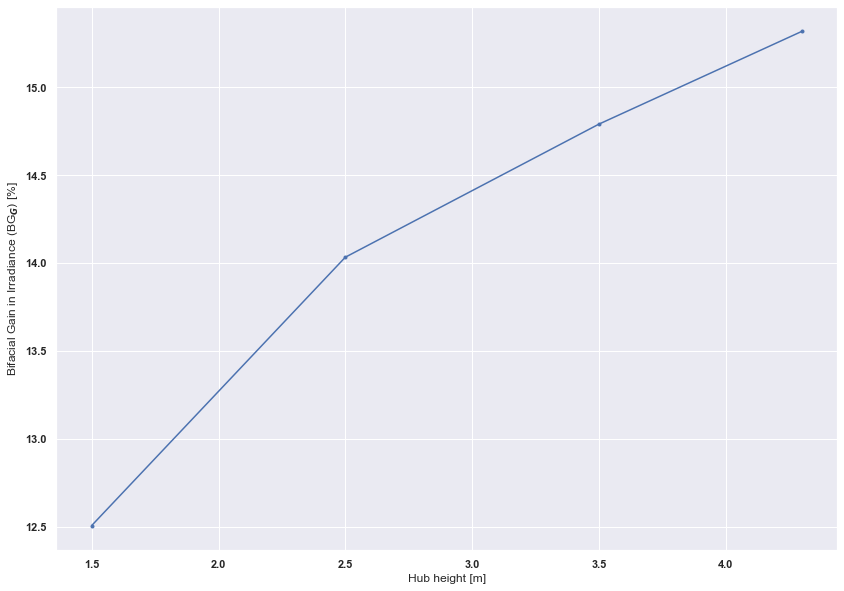

In [9]:
hub_heights = [4.3, 3.5, 2.5, 1.5]
results_BGG=[]
for i in range(0, len(hub_heights)):
    hub_height = str(int(hub_heights[i]*100))
    filepv= os.path.join(testfolder,'results',f'irr_height_{hub_height}cm_PV_6.csv')
    resultsDF = load.read1Result(filepv)
    resultsDF = load.cleanResult(resultsDF).dropna()
    results_BGG.append(resultsDF['Wm2Back'].sum()*100/resultsDF['Wm2Front'].sum())
    
plt.figure(figsize=(14,10))
plt.plot(hub_heights, results_BGG, '.-')
plt.ylabel('Bifacial Gain in Irradiance (BG$_G$) [%]')
plt.xlabel('Hub height [m]')

## 3. Plot Heatmaps of the Ground Irradiance

#### First, here is a complicated way to find hte maximum of all arrays so all heatmaps are referenced to that value

In [10]:
maxmax = 0
for hh in range (0, len(hub_heights)):
    for cc in range (0, len(crops)):
        filestarter = "irr_height_"+ str(int(hub_heights[hh]*100))+'cm_'+crops[cc]

        filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
        prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
        arrayWm2Front = []
        arrayWm2Back = []
        arrayMatFront = []
        arrayMatBack = []
        filenamed = []
        faillist = []

        print('{} files in the directory'.format(filelist.__len__()))
        print('{} groundscan files in the directory'.format(prefixed.__len__()))
        i = 0  # counter to track # files loaded.

        for i in range (0, len(prefixed)-1):
            ind = prefixed[i].split('_')
            #print(" Working on ", filelist[i], locs[ii], Scenario[jj])
            try:
                resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
                arrayWm2Front.append(list(resultsDF['Wm2Front']))
                arrayWm2Back.append(list(resultsDF['Wm2Back']))
                arrayMatFront.append(list(resultsDF['mattype']))
                arrayMatBack.append(list(resultsDF['rearMat']))
                filenamed.append(prefixed[i])
            except:
                print(" FAILED ", i, prefixed[i])
                faillist.append(prefixed[i])

        resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                          arrayMatFront, arrayMatBack)),
                                 columns = ['br_Wm2Front', 'br_Wm2Back', 
                                            'br_MatFront', 'br_MatBack'])
        resultsdf['filename'] = filenamed
        
        df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
        reversed_df = df3.T.iloc[::-1]
        
        if df3.max().max() > maxmax:
            maxmax = df3.max().max()


print("MAX Found", maxmax)

288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
288 files in the directory
30 groundscan files in the directory
MAX Found 800893.1333333333


tomato 4.3 Maximum irradiance: 800893.1333333333 Minimum irradiance 408316.6666666667
kale 4.3 Maximum irradiance: 271391.9666666666 Minimum irradiance 117187.7
tomato 3.5 Maximum irradiance: 797764.0666666668 Minimum irradiance 370674.6333333333
kale 3.5 Maximum irradiance: 268878.6333333333 Minimum irradiance 108065.1
tomato 2.5 Maximum irradiance: 797671.8666666667 Minimum irradiance 357065.60000000003
kale 2.5 Maximum irradiance: 248520.7333333333 Minimum irradiance 77751.82666666668
tomato 1.5 Maximum irradiance: 796366.5666666668 Minimum irradiance 238148.96666666665
kale 1.5 Maximum irradiance: 250413.56666666665 Minimum irradiance 74954.87666666666



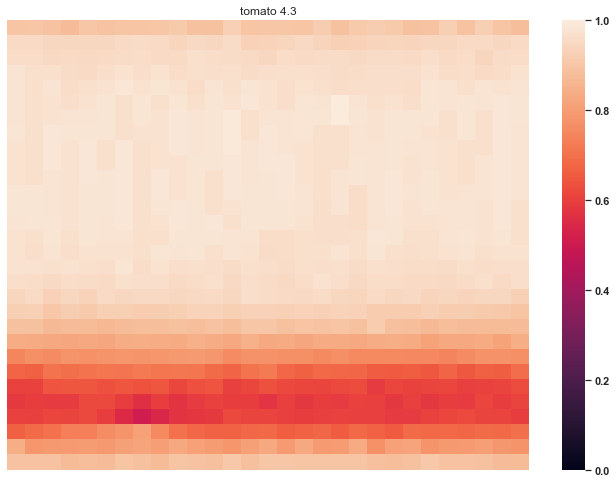

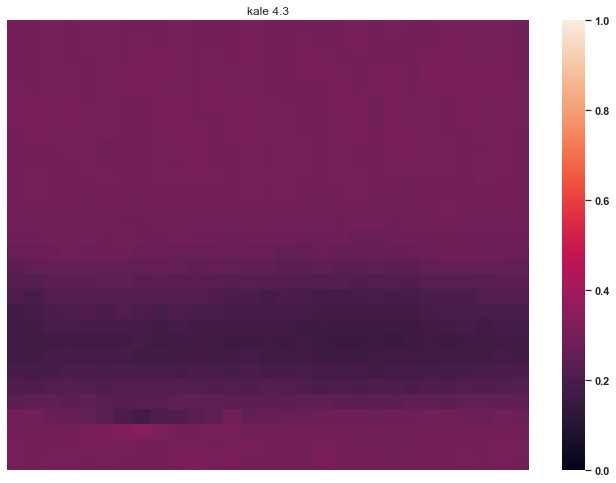

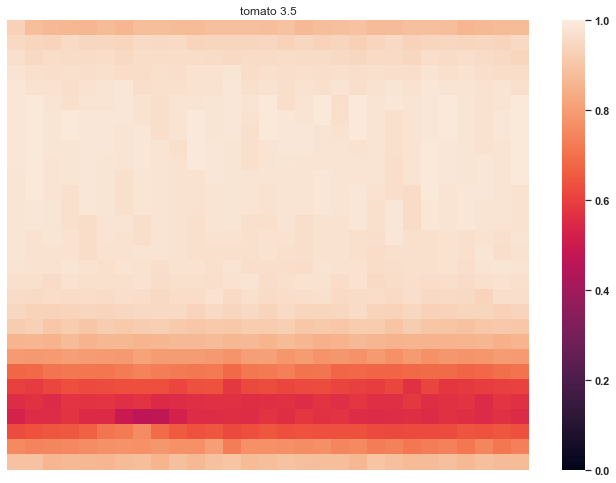

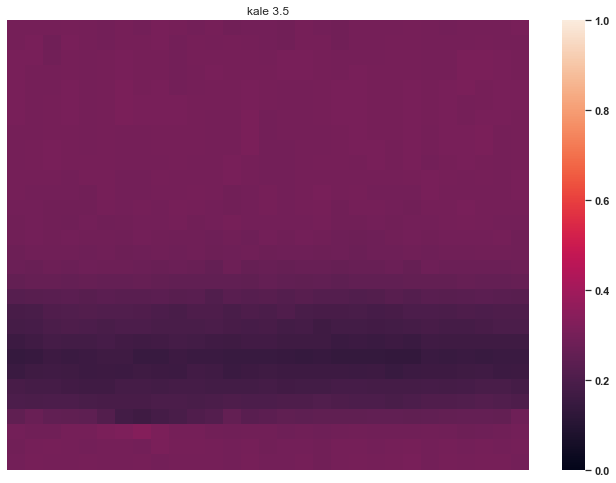

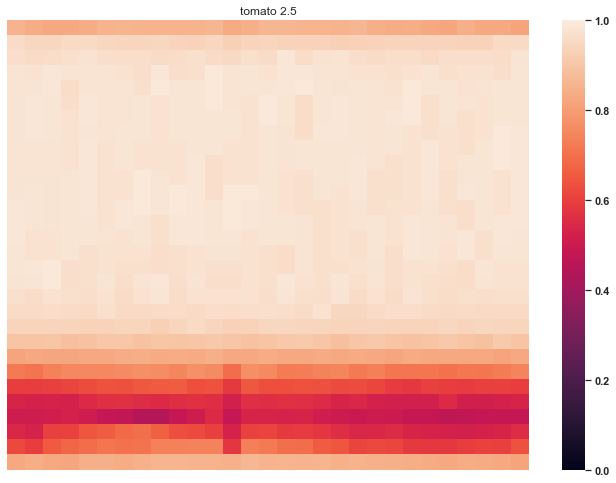

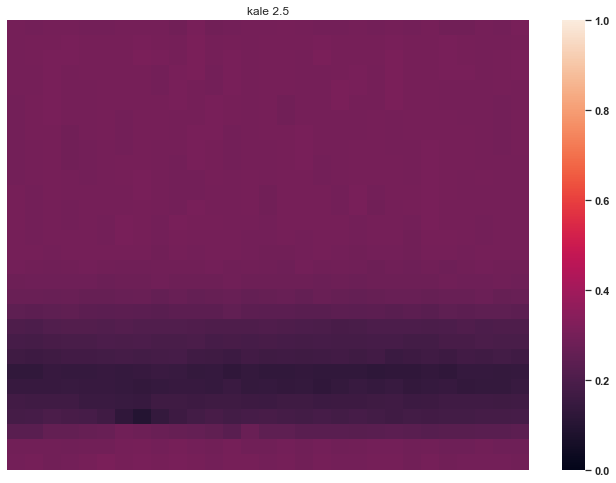

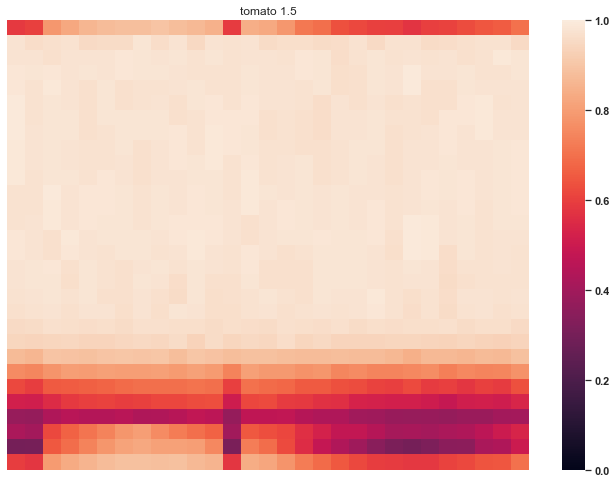

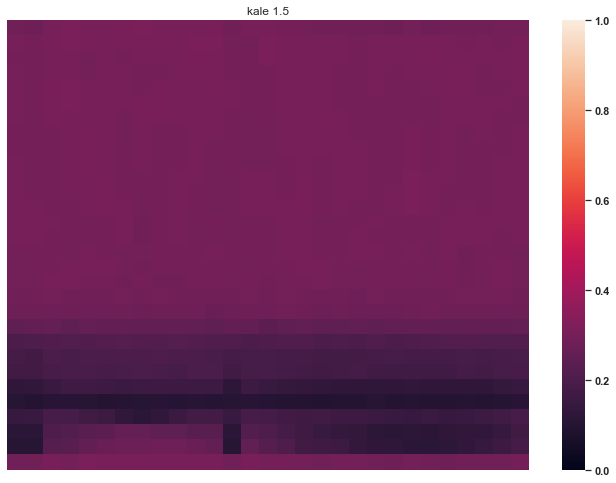

In [11]:
for hh in range (0, len(hub_heights)):
    for cc in range (0, len(crops)):
        filestarter = "irr_height_"+ str(int(hub_heights[hh]*100))+'cm_'+crops[cc]

        filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
        prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
        arrayWm2Front = []
        arrayWm2Back = []
        arrayMatFront = []
        arrayMatBack = []
        filenamed = []
        faillist = []

        i = 0  # counter to track # files loaded.

        for i in range (0, len(prefixed)-1):
            ind = prefixed[i].split('_')
            #print(" Working on ", filelist[i], locs[ii], Scenario[jj])
            try:
                resultsDF = load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
                arrayWm2Front.append(list(resultsDF['Wm2Front']))
                arrayWm2Back.append(list(resultsDF['Wm2Back']))
                arrayMatFront.append(list(resultsDF['mattype']))
                arrayMatBack.append(list(resultsDF['rearMat']))
                filenamed.append(prefixed[i])
            except:
                print(" FAILED ", i, prefixed[i])
                faillist.append(prefixed[i])

        resultsdf = pd.DataFrame(list(zip(arrayWm2Front, arrayWm2Back, 
                                          arrayMatFront, arrayMatBack)),
                                 columns = ['br_Wm2Front', 'br_Wm2Back', 
                                            'br_MatFront', 'br_MatBack'])
        resultsdf['filename'] = filenamed
        
        df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
        reversed_df = df3.T.iloc[::-1]
            
        plt.figure()
        ax = sns.heatmap(reversed_df/maxmax, vmin=0, vmax=1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel('')  
        ax.set_xlabel('')
        mytitle = crops[cc]+' '+str(hub_heights[hh])
        ax.set_title(mytitle)
        
        print(mytitle, "Maximum irradiance:", df3.max().max(), "Minimum irradiance", df3.min().min())

print("")